<a href="https://colab.research.google.com/github/Igor-Belskiy/AI_University/blob/main/%D0%9F%D0%BE%D0%BB%D0%BD%D0%BE%D1%81%D0%B2%D1%8F%D0%B7%D0%BD%D1%8B%D0%B5_%D0%B8_%D1%80%D0%B5%D0%BA%D1%83%D1%80%D1%80%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%B4%D0%BB%D1%8F_%D0%BF%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_(Light).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Работа осуществляется с базой акции Лукойла.

1. Обучите простую полносвязную сеть для прогнозирования временного ряда. Используйте только столбец close и визуализируйте результат.

2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.

3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слой

# Загрузка библиотек и данных

In [1]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras.utils import to_categorical 
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

import warnings
warnings.filterwarnings("ignore")
# Рисовать графики сразу же
%matplotlib inline

In [2]:
!rm -rf *      # Удаление всех каталогов и файлов в текущей директории

In [3]:
# Загружаем данные в колаб

import gdown
gdown.download('https://drive.google.com/uc?id=1g6CCPyp_UejO9O6Lon6KdL3fOVGGsCxz', '16_17.csv', quiet=False)
gdown.download('https://drive.google.com/uc?id=1Xk250F0NjfIaTrMgCFiEmo-qQ1ydf8Gq', '18_19.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1g6CCPyp_UejO9O6Lon6KdL3fOVGGsCxz
To: /content/16_17.csv
100%|██████████| 12.9M/12.9M [00:00<00:00, 40.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Xk250F0NjfIaTrMgCFiEmo-qQ1ydf8Gq
To: /content/18_19.csv
100%|██████████| 10.7M/10.7M [00:00<00:00, 42.2MB/s]


'18_19.csv'

In [13]:
#Считываем данные с помощью pandas

base_data_18_19 = pd.read_csv('/content/18_19.csv', sep=';')
base_data_16_17 = pd.read_csv('/content/16_17.csv', sep=';')

In [14]:
#Выводим пять первых строк
base_data_18_19.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [15]:
base_data_16_17.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,04.01.2016,10:00:00,2351.0,2355.8,2350.0,2350.0,2547
1,04.01.2016,10:01:00,2352.9,2355.7,2350.0,2355.7,195
2,04.01.2016,10:02:00,2355.6,2356.0,2351.4,2354.1,257
3,04.01.2016,10:03:00,2354.5,2355.0,2351.2,2353.7,763
4,04.01.2016,10:04:00,2353.1,2353.9,2353.1,2353.6,231


In [16]:
# Смотрим размер загруженных из файлов данных

print(base_data_16_17.shape)
print(base_data_18_19.shape)

(263925, 7)
(217947, 7)


In [18]:
data = pd.concat([base_data_16_17, base_data_18_19])  # Объединяем базы в одну

data.shape

(481872, 7)

In [19]:
#Оставляем для дальнейшей работы только последние 5 столбцов
data = data.iloc[:,2:]

data.head()

,OPEN,MAX,MIN,CLOSE,VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547
1,2352.9,2355.7,2350.0,2355.7,195
2,2355.6,2356.0,2351.4,2354.1,257
3,2354.5,2355.0,2351.2,2353.7,763
4,2353.1,2353.9,2353.1,2353.6,231


In [20]:
data = np.array(data)   #Превращаем в numpy массив

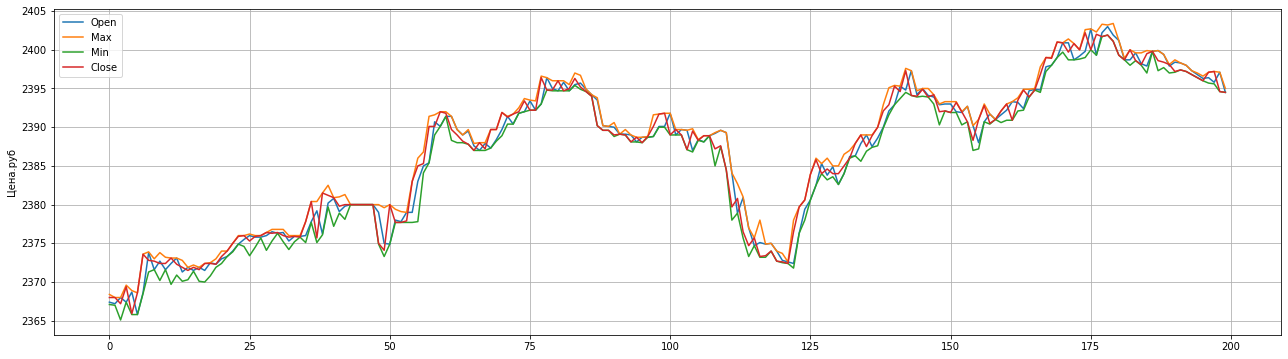

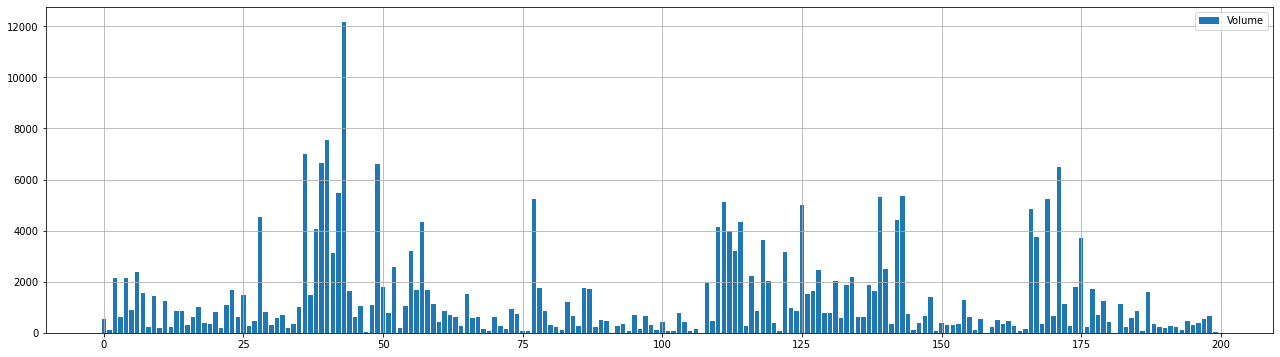

In [24]:
#Отображаем исходные данные от точки start и длинной length
start = 1000            #С какой точки начинаем
length = 200           #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

#Рисуем все графики данных
#ЧЕтыре основных канала - open, max, min, close
plt.figure(figsize=(22,6))
for i in range(4):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+length,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.grid()
plt.show()

#Канал volume
plt.figure(figsize=(22,6))
plt.bar(x=np.arange(length), height=data[start:start+length,4], label="Volume")
plt.legend()
plt.grid()
plt.show()

In [28]:
#Формируем параметры загрузки данных

xLen = 300                      #Анализируем по 300 прошедшим точкам 
valLen = 30000                  #Используем 30.000 записей для проверки

trainLen = data.shape[0]-valLen-xLen-2 # Размер тренировочной выборки

trainLen

451570

In [29]:
#Делим данные на тренировочную и тестовую выборки 
xTrain, xTest = data[:trainLen], data[trainLen+xLen+2:]

print(xTrain.shape)
print(xTest.shape)

(451570, 5)
(30000, 5)


In [30]:
#Масштабируем данные (отдельно для X и Y)
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)